Réponse exercice 1:

L'ensemble de données est peu conséquents et très inégalement réparti. En effet, bien que cela soit assez justifiable, nous avons un ensemble de données catégorisées "irrelevant" qui est prépondérant par rapport à toutes les autres catégories, il peut être avantageux de rééquilibrer l'ensemble de données.

En ce qui concerne les indices de performances fournis, on ne sait pas ce que représentent la précision, le recall et le F1 dans ce cas de classification multiclasse. 
Il est en général préférable d'avoir des indices de performances locaux en plus des indices de performance globaux.
Ici en particulier, nous ne savons pas comment sont calculés les valeurs données pour ces indices de performance que l'on suppose globaux. Cela permet notament d'observer le comportement du modèle pour chacune des catégories, en particulier dans cette situation où l'ensemble de données est déséquilibré.

De plus, nous ne savons pas comment ont été calculés les indices de performance fournis. En considérant que ce sont les indices de performance globaux, certaines définitions de ces indices entrainent que dans le cas multiclasse, la précision, le recall et le score F1 sont censés être égaux, on en conclut que ce n'est pas cette définition qui est utilisée ici. On ne peut donc que supposer ensuite que ces indices ont été calculés en faisant une moyenne des indices locaux, mais nous ne savons pas non plus si cette moyenne est pondérée ou non.
Il y a donc un manque en ce qui concerne la quantité d'indices de performances et dans leur définition (ce qu'ils représentent).

Visuellement, il peut aussi être intéressant d'avoir une courbe représentant la fonction de perte au fur et à mesure de l'entraînement (et éventuellement d'autre indices) pour observer l'évolution globale de la performance du réseau sur l'entraînement et la validation. Cela permettrait d'identifier un manque d'entraînement du réseau ou encore de l'overfitting par exemple.
Enfin, l'utilisation de matrices de confusion pour illustrer le comportement du réseau fasse à chacune des classes est également un ajout
que l'on pourrait avoir en parallèle des indices locaux et est souvent plus parlant.

Pour ce qui est de la visualisation du dataset, nous n'avons aucune idée des features utilisées dans le modèle, des 
features existantes de manières générale, de l'eventuelle corrélation entre les features et la sortie justifiant le choix
des features utilisées pour l'entraînement, etc.
Nous n'avons également aucune idée du type de modèle utlisé (FF, RNN, ...).

Tout d'abord, nous commençons par écrire le code pour tester le modèle.

In [15]:
from src.api_connector import get_intent_probabilities, get_most_probable_intent, api_score, get_all_intents
from src.visualization import plot_confusion_matrix, plot_distribution
from src.dataset import get_raw_training_data, get_raw_testing_data
from src.utils import limit_intent

import numpy as np

Maintenant que nous avons tous les outils pour tester le modèle, affichons un rapport plus détaillé des indices de performance.

In [10]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

In [11]:
trainig_metrics = api_score(raw_training_data)
testing_metrics = api_score(raw_testing_data)

In [12]:
print("TRAIN:")
print(trainig_metrics['report'])
print('-' * 60)
print("TEST:")
print(testing_metrics['report'])

TRAIN:
                   precision    recall  f1-score   support

   find-around-me       0.70      0.39      0.50       383
      find-flight       0.96      0.38      0.55       142
       find-hotel       0.86      0.48      0.62       316
  find-restaurant       0.91      0.61      0.73       469
       find-train       0.95      0.51      0.66       143
       irrelevant       0.80      0.98      0.88      3852
provide-showtimes       0.97      0.29      0.45       117
         purchase       0.76      0.56      0.65       613

         accuracy                           0.81      6035
        macro avg       0.86      0.53      0.63      6035
     weighted avg       0.81      0.81      0.79      6035

------------------------------------------------------------
TEST:
                   precision    recall  f1-score   support

   find-around-me       0.88      0.43      0.58        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.78      0.3

Comme nous l'avions mentionné précédemment, nous ne retrouvons pas les mêmes performances que celles indiquées sur l'extrait du README.
Nous disposons d'une accuracy de 0.81 sur le training set et de de 0.80 sur le test set.
Cela peut apparaître comme un bon résultat aux premiers abords mais en réalité ce n'est pas le cas.


Remarquons que la distribution des intentions de l'ensemble d'entraînement et de test n'est pas uniforme, presque 60% des intents sont ```irrelevant```.

Voici la répartition des intents de nos données:



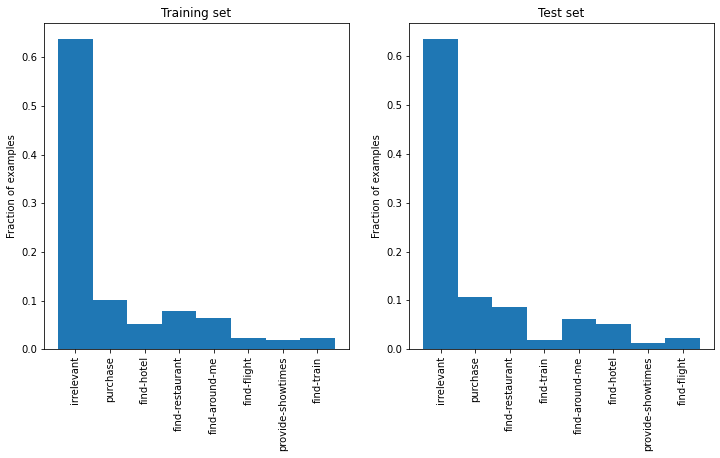

In [13]:
plot_distribution(raw_training_data, raw_testing_data)

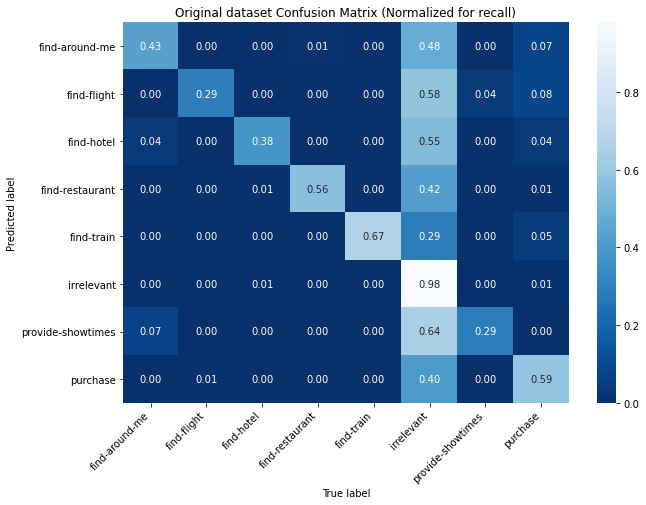

In [17]:
cm_testing_metrics = np.array(testing_metrics["cm"], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
    
plot_confusion_matrix(cm_testing_metrics,
                      labels=get_all_intents(),
                      title="Original dataset Confusion Matrix (Normalized for recall)", 
                      fmt=".2f")

On observe dans cette matrice de confusion que le modèle a tendance à catégoriser la majorité des données en "irrelevant", qu'elles le soient vraiment ou non. Ce problème pourrait provenir du modèle, mais l'inégale distribution des données en est probablement la cause principale, il faudrait réentrainer le modèle avec un dataset équilibré pour observer si le problème vient effectivement de l'ensemble de données ou non. Ce problème mis à part, il reste notable que le modèle catégorise en général soit correctement, soit en "irrelevant" la donnée ce qui est un comportement attendu. En effet, on ne souhaite pas dégrader l'expérience utilisateur en se trompant dans la prédiction, ainsi se rabattre sur "irrelevant" est un choix convenable.

Maintenant, qu'en est-il des métriques lorsque l'on diminue le nombre de irrelevants a seulement 613 ?

613 étant le nombre d'exemples de la deuxième classe la plus présente dans le training set.
On adopte ce nombre pour le test set qui vaut 114.

In [18]:
balanced_raw_training_data = limit_intent(raw_training_data, 'irrelevant', 613)
balanced_raw_testing_data = limit_intent(raw_testing_data, 'irrelevant', 114)

Voici la nouvelle distribution de nos données :

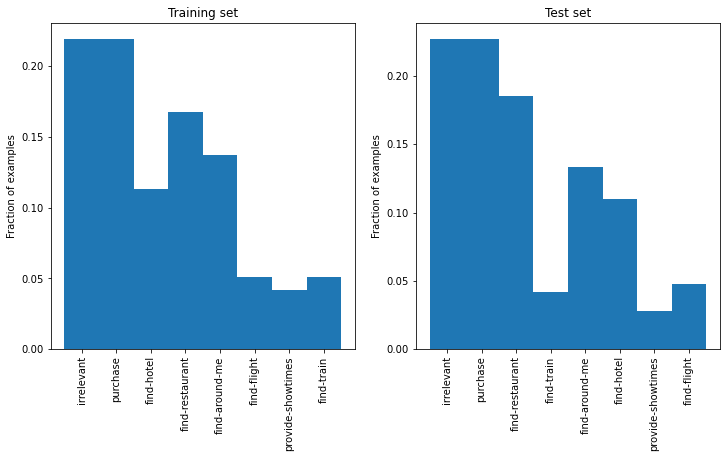

In [19]:
plot_distribution(balanced_raw_training_data, balanced_raw_testing_data)

Calculons à nouveau les métriques sur ce dataset un peu mieux distribué.

In [20]:
balanced_trainig_metrics = api_score(balanced_raw_training_data)
balanced_testing_metrics = api_score(balanced_raw_testing_data)

In [21]:
print("TRAIN:")
print(balanced_trainig_metrics['report'])
print('-' * 60)
print("TEST:")
print(balanced_testing_metrics['report'])

TRAIN:
                   precision    recall  f1-score   support

   find-around-me       0.76      0.39      0.51       383
      find-flight       0.96      0.38      0.55       142
       find-hotel       0.92      0.48      0.63       316
  find-restaurant       0.93      0.61      0.74       469
       find-train       0.95      0.51      0.66       143
       irrelevant       0.39      0.99      0.56       613
provide-showtimes       1.00      0.29      0.45       117
         purchase       0.83      0.56      0.67       613

         accuracy                           0.61      2796
        macro avg       0.84      0.53      0.60      2796
     weighted avg       0.77      0.61      0.62      2796

------------------------------------------------------------
TEST:
                   precision    recall  f1-score   support

   find-around-me       0.91      0.43      0.59        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.91      0.3

Nos scores passent de à.81 à 0.61 c'est catastrophique !

En fait, on pouvait s'y attendre, lorsque l'on regarde les recall individuels des autres classes sur les scores originaux, le meilleur score après 'irrelevant' est de 0.61 et le pire est à 0.29, c'est très loin de notre accuracy de 0.81 !